In [6]:
# Step 1: Importing necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor  # Importing RandomForestRegressor

Defaulting to user installation because normal site-packages is not writeable


In [7]:
# Step 2: Load the dataset 
df = pd.read_csv('pricing_data.csv')

In [8]:
# Step 3: Initial data exploration
print("First few rows of the dataset:")
print(df.head())

print("\nMissing values check:")
missing_values = df.isnull().sum()
print(f"Missing values:\n{missing_values}")

print("\nBasic statistics of the dataset:")
print(df.describe())

First few rows of the dataset:
  Product Id Product Category Name Month Year  Qty Total Price  \
0       bed1        bed_bath_table   1/5/2017    1      $45.95   
1       bed1        bed_bath_table   1/6/2017    3     $137.85   
2       bed1        bed_bath_table   1/7/2017    6     $275.70   
3       bed1        bed_bath_table   1/8/2017    4     $183.80   
4       bed1        bed_bath_table   1/9/2017    2      $91.90   

  Competitor Price Optimal Price  Product Name Lenght  \
0           $15.10        $45.95                   39   
1           $12.93        $45.95                   39   
2           $14.84        $45.95                   39   
3           $14.29        $45.95                   39   
4           $15.10        $45.95                   39   

   Product Description Lenght  Demand  ...  Comp 1  Ps1    Fp1  Comp 2  Ps2  \
0                         161       2  ...    89.9  3.9  15.01  215.00  4.4   
1                         161       2  ...    89.9  3.9  14.77  209.00 

In [9]:
# Step 4: Data cleaning
df = df.drop_duplicates()

In [10]:
# Step 5: Feature selection and preprocessing
target_variable = 'Optimal Price'  # Adjusted to the correct column name
# Remove the dollar sign and convert to numeric
df[target_variable] = df[target_variable].replace({r'\$': '', ',': ''}, regex=True).astype(float)

X = df.drop(target_variable, axis=1)  # Drop the target variable from features
y = df[target_variable]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))  # Only scale numerical features

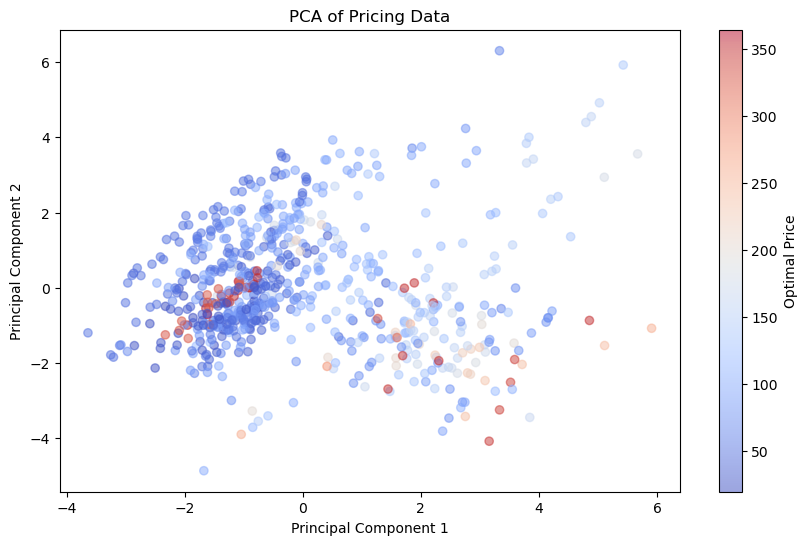

In [11]:
# Step 6: Feature Engineering - PCA (Principal Component Analysis)
# Reducing the number of features using PCA to explain variance in a reduced number of components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.title('PCA of Pricing Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Optimal Price')
plt.show()


In [12]:
# Step 7: Data Splitting for Model Training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
# Step 8: XGBoost Hyperparameter Tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42, objective='reg:squarederror'),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [15]:
# Step 9: XGBoost Model (Primary Model for Pricing Optimization Deployment)
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Make predictions and evaluate XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\nXGBoost MSE: {mse_xgb:.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")



XGBoost MSE: 150.4129
XGBoost R² Score: 0.9722


In [16]:
# Step 10: Random Forest Hyperparameter Tuning using GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rf,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              verbose=1,
                              n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

# Best parameters from Grid Search for Random Forest
print(f"Best parameters (Random Forest): {grid_search_rf.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters (Random Forest): {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 300}


In [17]:
# Step 11: Random Forest Model
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Make predictions and evaluate Random Forest
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest MSE: {mse_rf:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")


Random Forest MSE: 111.5367
Random Forest R² Score: 0.9794


In [18]:
# Step 12: Model Comparison
print(f"\nModel Comparison:")
print(f"XGBoost - MSE: {mse_xgb:.4f}, R² Score: {r2_xgb:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}, R² Score: {r2_rf:.4f}")


Model Comparison:
XGBoost - MSE: 150.4129, R² Score: 0.9722
Random Forest - MSE: 111.5367, R² Score: 0.9794


In [19]:
# Step 13: Calculate Demand Elasticity
def calculate_elasticity(df, price_col, demand_col):
    df['Price_Change'] = df[price_col].pct_change()
    df['Demand_Change'] = df[demand_col].pct_change()
    
    # Remove rows with NaN values
    df.dropna(inplace=True)
    
    # Calculate elasticity
    df['Elasticity'] = df['Demand_Change'] / df['Price_Change']
    
    # Average elasticity
    avg_elasticity = df['Elasticity'].mean()
    print(f"Average Price Elasticity: {avg_elasticity:.4f}")

# Apply the elasticity calculation
calculate_elasticity(df, 'Optimal Price', 'Demand')

Average Price Elasticity: -0.0489


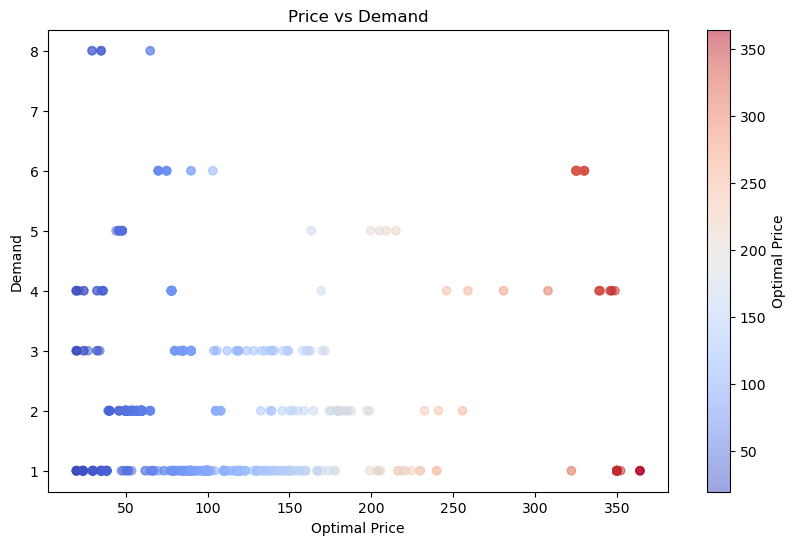

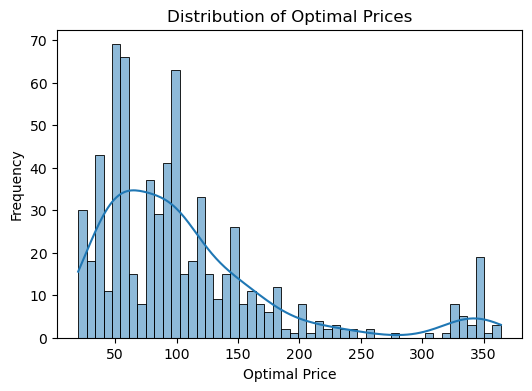

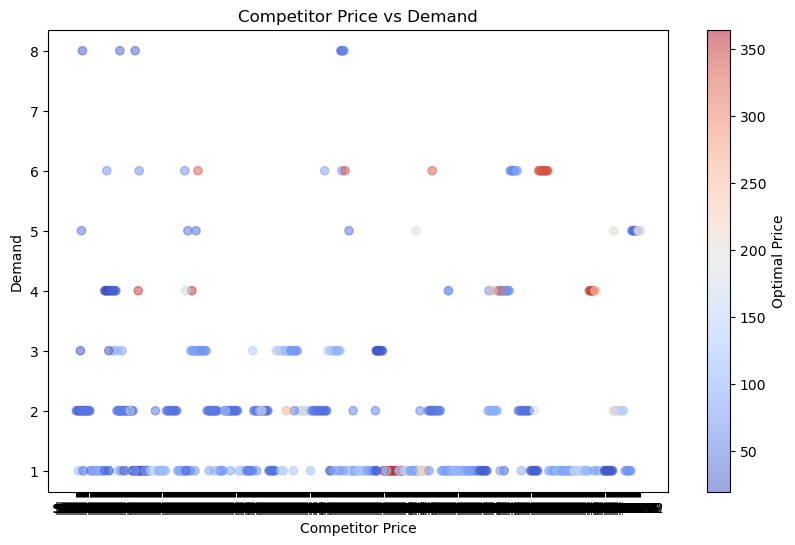

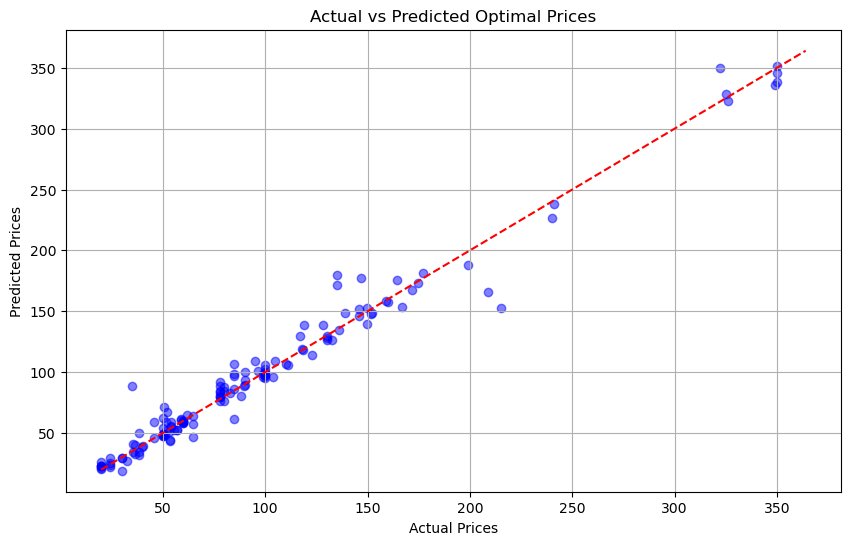

In [20]:
# Step 14: Data Visualization
# Price vs Demand Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df['Optimal Price'], df['Demand'], c=df['Optimal Price'], cmap='coolwarm', alpha=0.5)
plt.title('Price vs Demand')
plt.xlabel('Optimal Price')
plt.ylabel('Demand')
plt.colorbar(label='Optimal Price')
plt.show()

# Distribution of Optimal Prices
plt.figure(figsize=(6, 4))
sns.histplot(df['Optimal Price'], bins=50, kde=True)
plt.title('Distribution of Optimal Prices')
plt.xlabel('Optimal Price')
plt.ylabel('Frequency')
plt.show()

# Competitor Price vs Demand Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df['Competitor Price'], df['Demand'], c=df['Optimal Price'], cmap='coolwarm', alpha=0.5)
plt.title('Competitor Price vs Demand')
plt.xlabel('Competitor Price')
plt.ylabel('Demand')
plt.colorbar(label='Optimal Price')
plt.show()

# Actual vs Predictive Optimal Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, c='blue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Line of perfect prediction
plt.title('Actual vs Predicted Optimal Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid()
plt.show()


In [21]:
# Step 15: Summary Statistics for Demand
total_products = df.shape[0]
high_demand_products = df[df['Demand'] > df['Demand'].mean()].shape[0]
low_demand_products = df[df['Demand'] <= df['Demand'].mean()].shape[0]

print(f"\nTotal Products: {total_products}")
print(f"High-Demand Products: {high_demand_products}")
print(f"Low-Demand Products: {low_demand_products}")

# Evaluate XGBoost and Random Forest model performances
print(f"XGBoost RMSE: {np.sqrt(mse_xgb):.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")
print(f"Random Forest RMSE: {np.sqrt(mse_rf):.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")


Total Products: 675
High-Demand Products: 337
Low-Demand Products: 338
XGBoost RMSE: 12.2643
XGBoost R² Score: 0.9722
Random Forest RMSE: 10.5611
Random Forest R² Score: 0.9794


In [22]:
import joblib
joblib.dump(best_xgb_model, 'xgboost_model.joblib')


['xgboost_model.joblib']

In [43]:
import sys
print(sys.executable)


C:\ProgramData\anaconda3\python.exe


In [4]:
pip install flask

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
